In [1]:
from lake_model_outputspace_exploration import lake_problem

from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    Policy,
    SequentialEvaluator,
    OutputSpaceExploration
)

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)
lake_model.time_horizon = 100

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers, one for each time step
lake_model.levers = [
    RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)
]

# specify outcomes
# TODO kind argument can be ignored when doing
# output space exploration

lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
lake_model.constants = [Constant("alpha", 0.41), Constant("nsamples", 150)]

# generate some random policies by sampling over levers
n_scenarios = 1000
reference = Policy('nopolicy', **{l.name:0.02 for l in lake_model.levers})



# output space exploration

In [3]:
from ema_workbench.em_framework.optimization import EpsilonProgress

class Wrapper:
    # bit of a hack to get access to the inner state of the algorithm
    def __call__(self, problem, **kwargs):
        self.algorithm = OutputSpaceExploration(problem, **kwargs)
        return self.algorithm
wrapper = Wrapper()

In [14]:

convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for _ in range(5):
        convergence_metrics = [
            EpsilonProgress(),
        ]        
        res, convergence = evaluator.optimize(algorithm=OutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
27512it [01:43, 265.46it/s]                                                    
[MainProcess/INFO] optimization completed, found 1361 solutions
26828it [01:40, 267.59it/s]                                                    
[MainProcess/INFO] optimization completed, found 1373 solutions
28725it [01:47, 268.34it/s]                                                    
[MainProcess/INFO] optimization completed, found 1394 solutions
28258it [01:46, 266.58it/s]                                                    
[MainProcess/INFO] optimization completed, found 1392 solutions
27286it [01:42, 265.63it/s]                                                    
[MainProcess/INFO] optimization completed, found 1361 solutions
[MainProcess/INFO] terminating pool


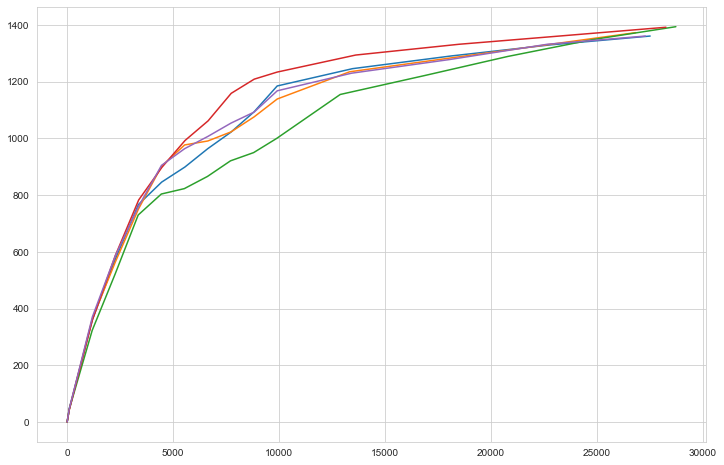

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

In [16]:
from ema_workbench.em_framework.optimization import BORGDefaultDescriptor

from platypus import (GAOperator,
                      DifferentialEvolution,
                      PM)

de_rate = 0.1
de_stepsize = 0.5

pm_p = 1/5
pm_dist = 20


variator = GAOperator(
    DifferentialEvolution(
        crossover_rate=de_rate, step_size=de_stepsize
    ),
    PM(probability=pm_p, distribution_index=pm_dist),
)

convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for _ in range(5):
        convergence_metrics = [
            EpsilonProgress(),
        ]        
        
        res, convergence = evaluator.optimize(algorithm=OutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 convergence=convergence_metrics,
                                 variator=variator)
        convergences.append(convergence)

[MainProcess/INFO] pool started with 10 workers
29080it [02:11, 220.73it/s]                                                    
[MainProcess/INFO] optimization completed, found 1417 solutions
29350it [02:01, 240.91it/s]                                                    
[MainProcess/INFO] optimization completed, found 1412 solutions
29665it [01:51, 265.79it/s]                                                    
[MainProcess/INFO] optimization completed, found 1412 solutions
30145it [01:53, 265.61it/s]                                                    
[MainProcess/INFO] optimization completed, found 1436 solutions
29200it [01:49, 266.25it/s]                                                    
[MainProcess/INFO] optimization completed, found 1408 solutions
[MainProcess/INFO] terminating pool


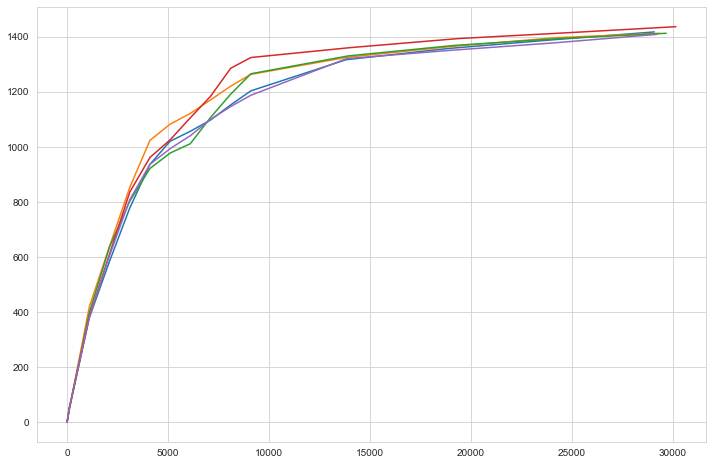

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

In [18]:
from ema_workbench.em_framework.output_space_exploration import AutoAdaptiveOutputSpaceExploration
from ema_workbench.em_framework.optimization import OperatorProbabilities



convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    
    for _ in range(5):
        convergence_metrics = [
            EpsilonProgress(),
            OperatorProbabilities("SBX", 0),
            OperatorProbabilities("PCX", 1),
            OperatorProbabilities("DE", 2),
            OperatorProbabilities("UNDX", 3),    
            OperatorProbabilities("SPX", 4),    
            OperatorProbabilities("UM", 5),    
        ]    
        res, convergence = evaluator.optimize(algorithm=AutoAdaptiveOutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 variator=None,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
29124it [01:52, 259.55it/s]                                                    
[MainProcess/INFO] optimization completed, found 1429 solutions
29706it [01:55, 257.31it/s]                                                    
[MainProcess/INFO] optimization completed, found 1429 solutions
30232it [04:35, 109.73it/s]                                                    
[MainProcess/INFO] optimization completed, found 1445 solutions
30183it [02:07, 237.29it/s]                                                    
[MainProcess/INFO] optimization completed, found 1439 solutions
29709it [02:57, 167.05it/s]                                                    
[MainProcess/INFO] optimization completed, found 1440 solutions
[MainProcess/INFO] terminating pool


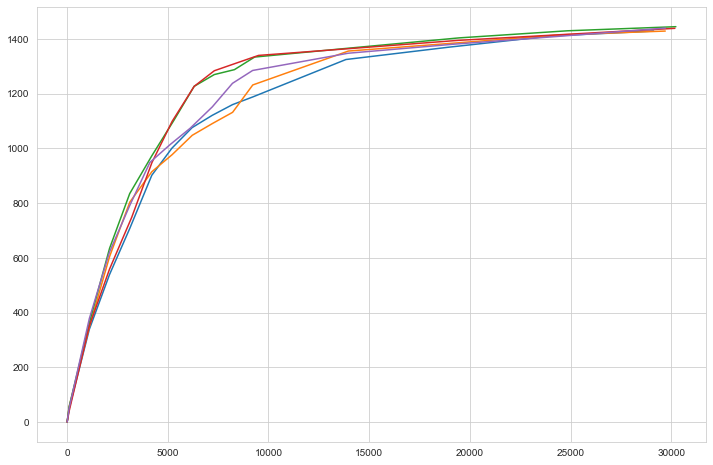

In [19]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

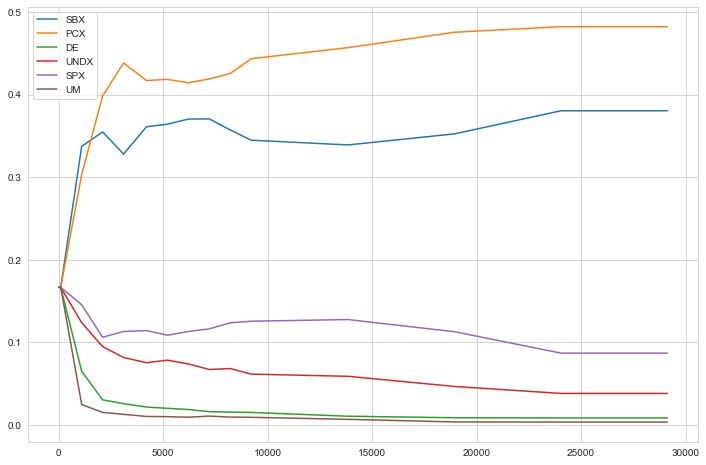

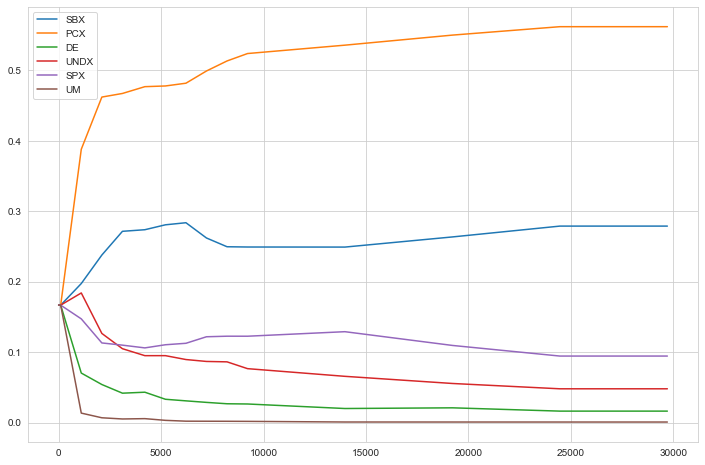

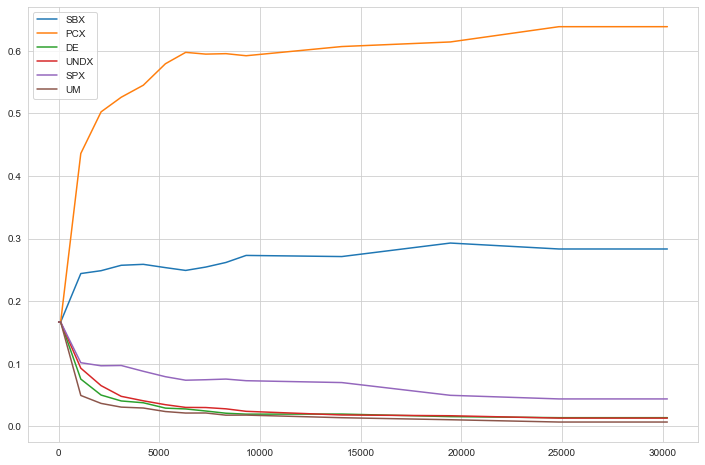

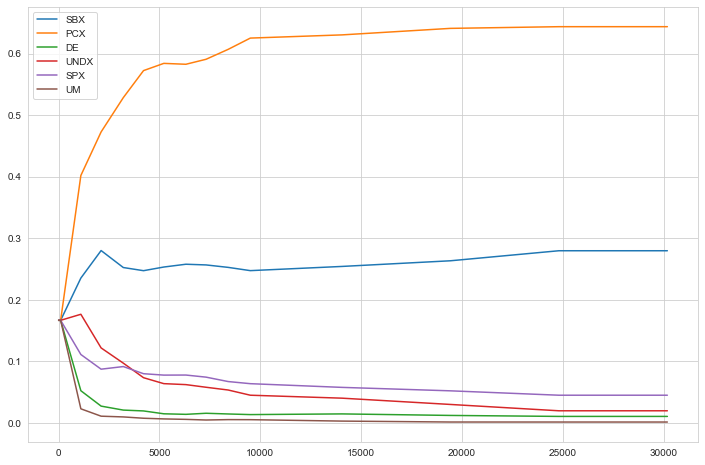

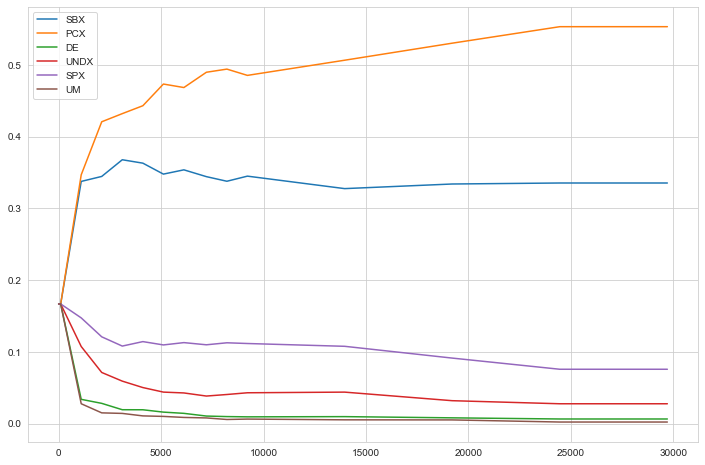

In [20]:



for convergence in convergences:
    fig, ax = plt.subplots()    
    ax.plot(convergence.nfe, convergence.SBX, label='SBX')
    ax.plot(convergence.nfe, convergence.PCX, label='PCX')
    ax.plot(convergence.nfe, convergence.DE, label='DE')
    ax.plot(convergence.nfe, convergence.UNDX, label='UNDX')
    ax.plot(convergence.nfe, convergence.SPX, label='SPX')
    ax.plot(convergence.nfe, convergence.UM, label='UM')
    ax.legend()
plt.show()

# LHS

In [27]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
                             scenarios=1000,
                             policies=reference)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:03<00:00, 297.62it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# comparison

In [11]:
outcomes = pd.DataFrame(outcomes)
outcomes['sampling'] = 'LHS'

In [12]:
ose = res.iloc[:, 5::].copy()
ose['sampling'] = 'OSE'

In [13]:
data = pd.concat([ose, outcomes], axis=0,ignore_index=True)

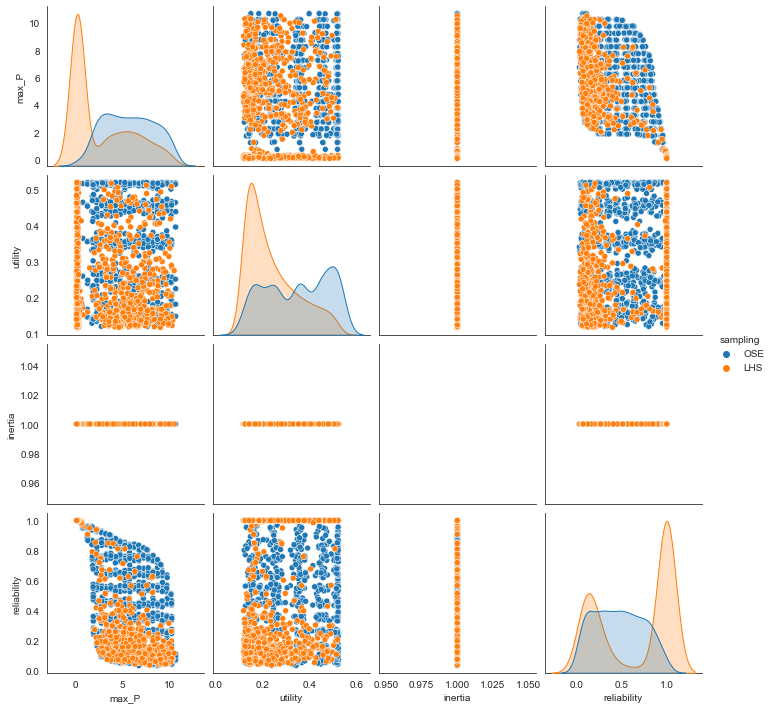

In [14]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(data, hue='sampling', vars=data.columns[0:4])
plt.show()

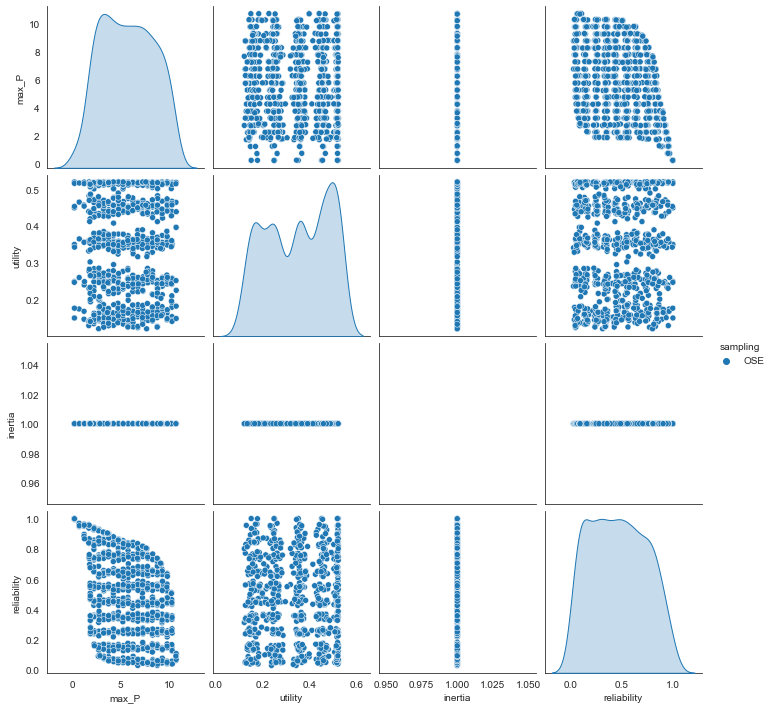

In [15]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(ose, hue='sampling', vars=data.columns[0:4])
plt.show()